In [45]:
import shutil
import joblib
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize 
from textblob import TextBlob
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
import re
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from textblob import TextBlob
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import gensim
from joblib import load

In [141]:

print(f"gensim version: {gensim.__version__}")
print(f"matplotlib version: {plt.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"spotipy version: {spotipy.__version__}")

gensim version: 4.3.0


AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

In [134]:

def process_new_sample(episode_id):
    """
    处理新样本，生成完整特征向量（包括主题概率向量和情绪特征）。
    
    参数:
    - new_sample_description: 新样本的描述。
    - other_features: 新样本的其他数值特征（如时长）。
    - stop_words: 停用词集合。
    - lda_model: 已训练的 LDA 模型。
    - dictionary: LDA 模型的词典。
    
    返回:
    - combined_features: 新样本的完整特征向量。
    """
    
    # 设置客户端凭证（client_id 和 client_secret）
    client_id = "a728a5852093450cacb79d3106c5002f"
    client_secret = "d9b1e1a9b0b7401e96163b2330ae2a46"

    # 使用 client credentials flow 进行身份验证
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    # 使用 spotipy 获取 episode 信息
    episode = sp.episode(episode_id)

    # 提取 episode 信息
    podcast_name = episode['show']['name']  # 提取播客名称
    podcast_description = episode['show']['description']
    episode_name = episode['name']
    episode_description = episode['description']
    episode_duration_ms = episode['duration_ms']  # Duration in milliseconds

    combined_description = podcast_description + episode_description
    
    #Step 0: 预设参数及函数
    lda_model = gensim.models.LdaModel.load('lda_model.gensim')
    dictionary = lda_model.id2word
    
    scaled_features = pd.read_csv('reduced.csv', header=0)
    scaled_features = np.array(scaled_features)
    scaled_features = scaled_features[:, 1:3]
    
    df = pd.read_csv('result.csv')
    data = df.iloc[:, 0:9]
    stop_words = set(stopwords.words('english'))
    custom_stopwords = stop_words.union({
        'podcast', 'episode', 'show', 'episodes', '’', '“', '”', 'us', 
        'one', 'get', 'new', 'week', 'every', 'join', 'like', 'also',
        'first', 'free', 'today', 'ad', 'make', 'find', 'day', 'go',
        'use', 'daily', 'instagram', 'youtube',  'hosted',"— ","n't","ad-free", "—","com","podcasts","–","?",
         'support'
    })
    
    def remove_emoji_and_urls(text):
        """
        删除文本中的 emoji 表情和 URL 链接
        """
        if not isinstance(text, str):
            return text

        # 删除 URL 链接
        text = re.sub(r"http[s]?://\S+|www\.\S+", "", text)

        # 删除 Emoji 表情
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # 表情符号
            u"\U0001F300-\U0001F5FF"  # 符号 & 图标
            u"\U0001F680-\U0001F6FF"  # 运输 & 地图图标
            u"\U0001F700-\U0001F77F"  # Alchemical Symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U00002702-\U000027B0"  # Dingbats
            u"\U000024C2-\U0001F251"  # Enclosed characters
            "]+", flags=re.UNICODE
        )
        text = emoji_pattern.sub(r"", text)

        return text
    
    def clean_text(text, stop_words):
        """
        清理文本，包括删除 Emoji、URL、标点、小写、移除停用词等。
        """
        text = remove_emoji_and_urls(text)  # 删除 emoji 和 URL
        text = re.sub(r'[^\w\s]', '', text.lower())  # 转换为小写并去掉标点
        tokens = [word for word in text.split() if word not in stop_words]  # 移除停用词
        return ' '.join(tokens)
    
    def extract_sentiment_features(text):
        """
        从文本中提取情绪极性和主观性。
        """
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity
        return polarity, subjectivity
    
    # Step 1: 清理文本
    cleaned_description = clean_text(combined_description, stop_words)
    
    # Step 2: 转换描述为 LDA 主题概率向量
    bow = dictionary.doc2bow(cleaned_description.split())
    topic_vector = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_vector = [prob for _, prob in sorted(topic_vector, key=lambda x: x[0])]
    
    # Step 3: 提取情感特征
    polarity, subjectivity = extract_sentiment_features(combined_description)
    
    # Step 4: 组合完整特征
    combined_features = np.hstack([topic_vector, episode_duration_ms, [polarity, subjectivity]]).reshape(1, -1)
    
    # Step 5: Standardize the new sample's features
    scaler = load('scaler_model.joblib')
    scaled_new_sample = scaler.transform(combined_features)
    
    # Step 6: Compute distances to all samples
    pca_model = load('pca_model.joblib')
    transformed_data = pca_model.transform(scaled_new_sample)
    transformed_data = transformed_data[0, 0:2].reshape(1, -1)
    distances = euclidean_distances(transformed_data, scaled_features).flatten()    
    
    # Step 7: Find the nearest samples
    nearest_indices = distances.argsort()[:5]
    nearest_episodes = data.iloc[nearest_indices].copy()
    nearest_episodes['Distance'] = distances[nearest_indices]
     
    
    #Step 8: Plotting
#     pca_model = load('pca_model.joblib')
#     transformed_data = pca_model.transform(scaled_new_sample)
#     transformed_data = transformed_data[0,0:2]
    
    scaled_features = pd.DataFrame(scaled_features)
    result = scaled_features.iloc[nearest_episodes['Unnamed: 0']] 
    pc1 = transformed_data[0,0]
    pc2 = transformed_data[0,1]
    result_pc1 = result[0]  
    result_pc2 = result[1]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(scaled_features[0], scaled_features[1], color='green', s=5, marker='x', label='all points')
    plt.scatter(pc1, pc2, color='red', s=100, label='episode you like')
    plt.scatter(result_pc1, result_pc2, color='blue', s=150, marker='x', label='selected points')
    plt.title('PCA Result (2D Projection)', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    return nearest_episodes


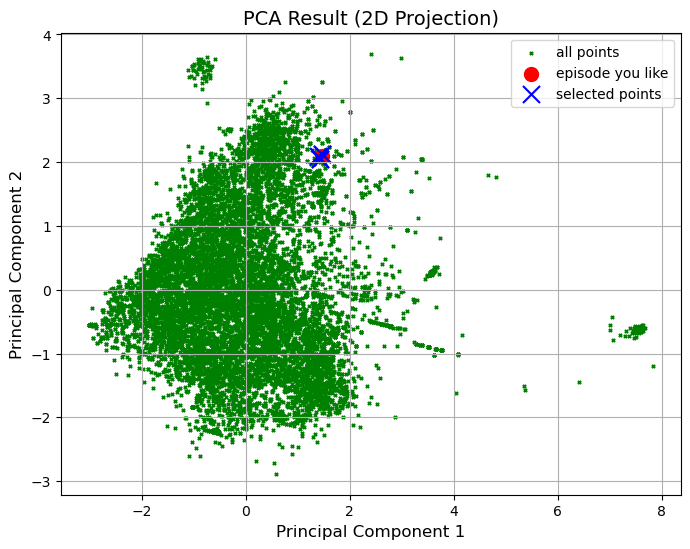

,Unnamed: 0,Podcast Name,Podcast ID,Podcast Description,Episode Name,Episode ID,Episode Description,Release Date,Duration (ms),Distance
2037,2037,Modern Wisdom,0XrOqvxlqQI6bmdYHuIVnr,Life lessons from the greatest thinkers on the...,#863 - Matthew McConaughey - The Hidden Art Of...,2VzVgDcHpBBWCHKvMJuyeN,Matthew McConaughey is an Academy Award winnin...,2024-11-11,6525973,0.029987
7473,7473,Modern Wisdom,0XrOqvxlqQI6bmdYHuIVnr,Life lessons from the greatest thinkers on the...,#863 - Matthew McConaughey - The Hidden Art Of...,2VzVgDcHpBBWCHKvMJuyeN,Matthew McConaughey is an Academy Award winnin...,2024-11-11,6525973,0.029988
7486,7486,Modern Wisdom,0XrOqvxlqQI6bmdYHuIVnr,Life lessons from the greatest thinkers on the...,"#850 - 2.75M Q&A - Women’s Value, Loneliness &...",1xIlonIODs9hjCPPWfz5aW,I hit 2.75 million Subscribers on YouTube!!To ...,2024-10-12,6231797,0.057244
2050,2050,Modern Wisdom,0XrOqvxlqQI6bmdYHuIVnr,Life lessons from the greatest thinkers on the...,"#850 - 2.75M Q&A - Women’s Value, Loneliness &...",1xIlonIODs9hjCPPWfz5aW,I hit 2.75 million Subscribers on YouTube!!To ...,2024-10-12,6231797,0.057244
2072,2072,Modern Wisdom,0XrOqvxlqQI6bmdYHuIVnr,Life lessons from the greatest thinkers on the...,#828 - Dan Bilzerian - What Happened To Dan Bi...,0ecATZLBDBZlmgvzJdutYf,Dan Bilzerian is an entrepreneur and a profess...,2024-08-22,7233541,0.068325


In [136]:
process_new_sample("2VzVgDcHpBBWCHKvMJuyeN")